# Locust Prediction Modelling

Notes:

- `observation_date` is already encoded as `year`, `month`, `day`, separately
- The `dekad` variables are used for pseudo-absence generation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_train = pd.read_csv("../data/train_val_random.csv", index_col=0)
data_test = pd.read_csv("../data/test_random.csv", index_col=0)
data_train.head()

,Unnamed: 0.1,x,y,presence,method,year,month,day,clay_0.5cm_mean,clay_5.15cm_mean,...,SoilMoi0_10cm_inst_95,SoilMoi10_40cm_inst_95,SoilTMP0_10cm_inst_95,SoilTMP10_40cm_inst_95,Tveg_tavg_95,Wind_f_inst_95,Rainf_f_tavg_95,Tair_f_inst_95,Qair_f_inst_95,Psurf_f_inst_95
0,0,-13.899444,19.156944,1,random,2000,11,27,213.0,218.0,...,21.949375,72.536621,309.327972,308.586700,0.0,2.366373,0.0,308.427795,0.006704,98936.21875
1,1,-13.910278,19.144444,1,random,2000,11,27,212.0,217.0,...,21.949375,72.536621,309.327972,308.586700,0.0,2.366373,0.0,308.427795,0.006704,98936.21875
2,2,-13.923056,19.146667,1,random,2000,11,27,210.0,215.0,...,21.949375,72.536621,309.327972,308.586700,0.0,2.366373,0.0,308.427795,0.006704,98936.21875
3,3,-12.945833,19.146389,1,random,2000,11,28,175.0,190.0,...,21.541126,71.466125,308.702087,309.064667,0.0,3.542690,0.0,307.616486,0.010070,99162.62500
4,4,-12.949722,19.133056,1,random,2000,11,28,180.0,191.0,...,21.541126,71.466125,308.702087,309.064667,0.0,3.542690,0.0,307.616486,0.010070,99162.62500


In [3]:
# assert len(data_train.drop(columns="presence").columns), len(data_test.columns)
missing_in_train = [n for n in data_test.columns if n not in data_train.columns]
missing_in_test = [n for n in data_train.columns if n not in data_test.columns]
missing_in_background = [n for n in background.columns if n not in background.columns]

print(f"Train missing {len(missing_in_train)} columns")
print(f"Test missing {len(missing_in_test)} columns")
print(f"Background missing {len(missing_in_background)} columns")

data_test = data_test.drop(columns=missing_in_train)
data_train = data_train.drop(columns=missing_in_test)

Train missing 0 columns
Test missing 0 columns


In [4]:
cats = data_train.select_dtypes(np.integer).columns.tolist()
objects = data_train.select_dtypes(np.object).columns.tolist()
floats = data_train.select_dtypes(np.float).columns.tolist()
assert len(cats) + len(objects) + len(floats) == len(data_train.columns)

print("Objects:", objects)
print("Categoricals:", cats)
print("Floats:", floats[:10])

Objects: ['method', 'observation_date']
Categoricals: ['Unnamed: 0.1', 'presence', 'year', 'month', 'day']
Floats: ['x', 'y', 'clay_0.5cm_mean', 'clay_5.15cm_mean', 'sand_0.5cm_mean', 'sand_5.15cm_mean', 'silt_0.5cm_mean', 'silt_5.15cm_mean', 'AvgSurfT_inst_0', 'Albedo_inst_0']


/tmp/ipykernel_511806/3237200483.py:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  objects = data_train.select_dtypes(np.object).columns.tolist()
/tmp/ipykernel_511806/3237200483.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  floats = data_train.select_dtypes(np.float).columns.tolist()


In [5]:
data_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33246 entries, 0 to 76512
Columns: 1167 entries, Unnamed: 0.1 to Psurf_f_inst_95
dtypes: float64(1160), int64(5), object(2)
memory usage: 296.3+ MB


In [6]:
# Check for NAN values
nans = data_train.isnull().sum()
# [(k,v,d) for k,v,d in zip(nans.keys(), nans.values, data_train.dtypes) if v>0]

In [7]:
# Fill NAN values with median
# for col in data_train.columns:
#     n_train_nans = pd.isnull(data_train[col]).sum()
#     n_test_nans = pd.isnull(data_test[col]).sum()
#     if data_train[col].dtype == np.float:
#         m = data_train[col].median()
#         if n_train_nans:
#             data_train[col] = data_train[col].fillna(m)
#         if n_test_nans:
#             data_test[col] = data_test[col].fillna(m)

data_train.dropna(inplace=True)
data_test.dropna(inplace=True)
background.dropna(inplace=True)

assert not data_train.isnull().sum().sum()
assert not data_test.isnull().sum().sum()

In [8]:
non_temporal_columns = ['sand_0.5cm_mean', 'sand_5.15cm_mean',] #'clay_0.5cm_mean', 'clay_5.15cm_mean', 'silt_0.5cm_mean', 'silt_5.15cm_mean']
temporal_variables = [
    'AvgSurfT_inst', 
#     'Albedo_inst', 
    'SoilMoi0_10cm_inst', 
    'SoilMoi10_40cm_inst', 
    'SoilTMP0_10cm_inst', 
    'SoilTMP10_40cm_inst', 
#     'Tveg_tavg', 
#     'Wind_f_inst', 
#     'Rainf_f_tavg', 
#     'Tair_f_inst',
#     'Qair_f_inst', 
#     'Psurf_f_inst'
]

def grouplen(sequence, chunk_size):
    return list(zip(*[iter(sequence)] * chunk_size))

def preprocess_data(data, start_day=7, days=6, drop_true_absence=True, bucketize=True):
    """Bucketize temporal columns"""
    if drop_true_absence:
        data = data[data['presence'] != 2]
    dfs = []
    for temp_variable in temporal_variables:
        if bucketize:
            columns = [f"{temp_variable}_{i}" for i in range(start_day, 95+1)]
            chunks = grouplen(columns, days)
            agg_list = list(map(lambda x: data[list(x)].mean(axis=1), chunks))
            df = pd.concat(agg_list, axis=1)
            df.columns = [f"{temp_variable}_bucket_{i}" for i in range(1, df.shape[1]+1)]
        else:
            columns = [f"{temp_variable}_{i}" for i in range(start_day, 95+1)]
            df = data[columns]
        dfs.append(df)
    dfs.append(data[non_temporal_columns])
    return pd.concat(dfs, axis=1), data['presence']

In [9]:
# drops = ["observation_date", "date", "Unnamed: 0.1", "presence"]

# def process_targets(data):
#     target = data.presence.copy()
#     data = data.drop(columns=drops)
#     counts = list(zip(*np.unique(target, return_counts=True)))
#     print("Counts:", counts)
    
#     # merge pseudo-absence and true absence
#     target.loc[target == 2] = 0
#     return data, target

In [10]:
data_train, train_target = preprocess_data(data_train)
data_test, test_target = preprocess_data(data_test)

print(f"Train features: {data_train.shape}, Train labels: {train_target.shape}")
print(f"Test features: {data_test.shape}, Test labels: {test_target.shape}")

Train features: (32823, 178), Train labels: (32823,)
Test features: (6885, 178), Test labels: (6885,)


In [77]:
data_train["presence"] = train_target
data_test["presence"] = test_target
data_background["presence"] = background_target

In [78]:
data_background.to_csv("../data/preprocessed_background_data_updated.csv_full.csv")

In [79]:
data_train.to_csv("../data/preprocessed_train_val_random.csv")

In [80]:
data_test.to_csv("../data/preprocessed_test_random.csv")

## Modelling

In [11]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

In [12]:
def evaluate(trues, preds, probs):
    labels = ['absence', 'presence']
    results = {}
    results['accuracy'] = metrics.accuracy_score(trues, preds)
    results['confusion_matrix'] = metrics.confusion_matrix(trues, preds)
    results['kappa'] = metrics.cohen_kappa_score(trues, preds)
    results['f1'] = metrics.f1_score(trues, preds)
    results['auc'] = metrics.roc_auc_score(trues, probs)
    
    print(metrics.classification_report(trues, preds, target_names=labels))
    return results

In [13]:
# Probably should split data sooner
seed = 111
train_x, val_x, train_y, val_y = train_test_split(
    data_train, train_target, test_size=0.2, random_state=seed)

## Logistic Regression

In [14]:
# Scale the dataset
scaler = preprocessing.StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
val_x_scaled = scaler.transform(val_x)
test_x_scaled = scaler.transform(data_test)

In [15]:
model = LogisticRegression()
model.fit(train_x_scaled, train_y);

/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
y_preds = model.predict(val_x_scaled)
y_probs = model.predict_proba(val_x_scaled)[:, 1]
logistic_val_results = evaluate(val_y, y_preds, y_probs)

              precision    recall  f1-score   support

     absence       0.66      0.40      0.50      2359
    presence       0.72      0.89      0.80      4206

    accuracy                           0.71      6565
   macro avg       0.69      0.64      0.65      6565
weighted avg       0.70      0.71      0.69      6565



In [17]:
y_preds = model.predict(test_x_scaled)
y_probs = model.predict_proba(test_x_scaled)[:, 1]
logistic_test_results = evaluate(test_target, y_preds, y_probs)

              precision    recall  f1-score   support

     absence       0.49      0.52      0.50      1232
    presence       0.89      0.88      0.89      5653

    accuracy                           0.82      6885
   macro avg       0.69      0.70      0.70      6885
weighted avg       0.82      0.82      0.82      6885



In [18]:
# Feature importance
weights = model.coef_[0].tolist()
features = list(zip(weights, data_train.columns))
list(sorted(features, key=lambda x: abs(x[0]), reverse=True))[:10]

[(-1.5817677782900852, 'Tair_f_inst_bucket_16'),
 (1.4095284713943972, 'SoilTMP10_40cm_inst_bucket_16'),
 (1.2249959374559176, 'sand_0.5cm_mean'),
 (-1.149305523201153, 'Tair_f_inst_bucket_2'),
 (-1.1325072029398453, 'Tair_f_inst_bucket_1'),
 (-1.042188801310214, 'sand_5.15cm_mean'),
 (-1.006401287019596, 'Tair_f_inst_bucket_3'),
 (-0.9745902109473867, 'Tair_f_inst_bucket_14'),
 (-0.9349365050001243, 'Tair_f_inst_bucket_15'),
 (-0.8802094437176424, 'Psurf_f_inst_bucket_11')]

### XGBoost

In [19]:
train_xgb = xgb.DMatrix(train_x, label=train_y)
val_xgb = xgb.DMatrix(val_x, label=val_y)
test_xgb = xgb.DMatrix(data_test)

In [20]:
params = {'max_depth': 5, 'eta': 0.3, 'objective': 'binary:logistic', 'subsample': 0.7}
model = xgb.train(params, train_xgb)
y_probs = model.predict(val_xgb)
y_preds = y_probs.round()
xgb_val_results = evaluate(val_y, y_preds, y_probs)

[18:52:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

     absence       0.75      0.56      0.65      2359
    presence       0.79      0.90      0.84      4206

    accuracy                           0.78      6565
   macro avg       0.77      0.73      0.74      6565
weighted avg       0.77      0.78      0.77      6565



In [21]:
y_probs = model.predict(test_xgb)
y_preds = y_probs.round()
xgb_test_results = evaluate(test_target, y_preds, y_probs)

              precision    recall  f1-score   support

     absence       0.39      0.40      0.39      1232
    presence       0.87      0.86      0.86      5653

    accuracy                           0.78      6885
   macro avg       0.63      0.63      0.63      6885
weighted avg       0.78      0.78      0.78      6885



#### Feature Importance

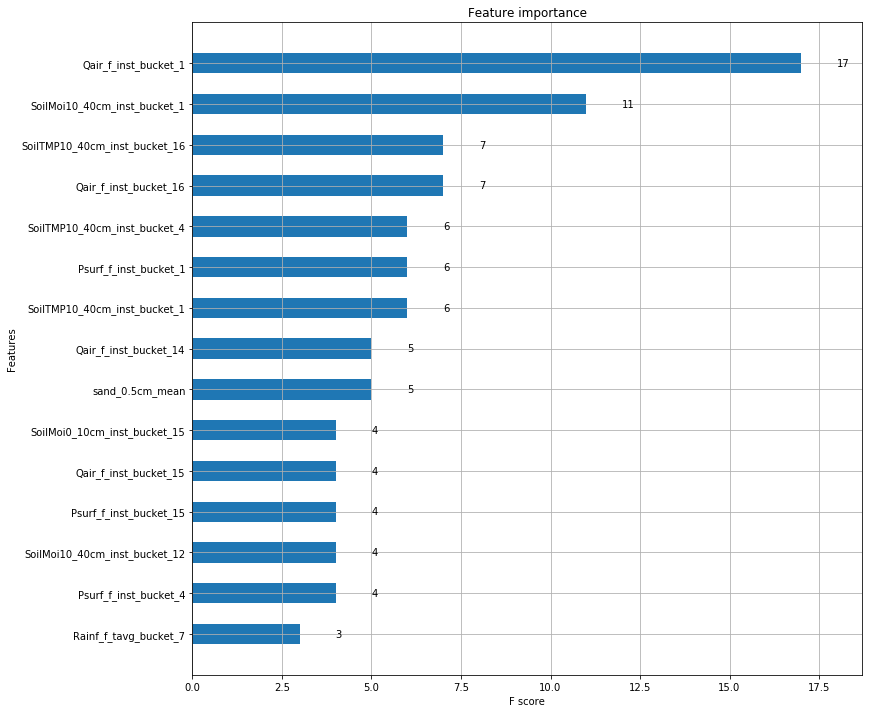

In [22]:
f,a = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, height=0.5, figure=f, ax=a, max_num_features=15);

### Random Forest

In [23]:
model = RandomForestClassifier(n_estimators=500, max_depth=5, min_samples_leaf=50)
model.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [24]:
y_preds = model.predict(val_x)
y_probs = model.predict_proba(val_x)[:, 1]
rf_val_results = evaluate(val_y, y_preds, y_probs)

              precision    recall  f1-score   support

     absence       0.68      0.49      0.57      2359
    presence       0.75      0.87      0.81      4206

    accuracy                           0.73      6565
   macro avg       0.72      0.68      0.69      6565
weighted avg       0.73      0.73      0.72      6565



In [25]:
y_preds = model.predict(data_test)
y_probs = model.predict_proba(data_test)[:, 1]
rf_test_results = evaluate(test_target, y_preds, y_probs)

              precision    recall  f1-score   support

     absence       0.04      0.02      0.02      1232
    presence       0.81      0.92      0.86      5653

    accuracy                           0.75      6885
   macro avg       0.42      0.47      0.44      6885
weighted avg       0.67      0.75      0.71      6885



## Results

### Validation

In [27]:
val_results = pd.DataFrame({
    "Logistic": logistic_val_results, 
    "XGBoost": xgb_val_results, 
    "Random Forest": rf_val_results,
})
val_results

,Logistic,XGBoost,Random Forest
accuracy,0.711196,0.777304,0.73374
confusion_matrix,"[[941, 1418], [478, 3728]]","[[1331, 1028], [434, 3772]]","[[1159, 1200], [548, 3658]]"
kappa,0.312601,0.488017,0.384344
f1,0.797263,0.837664,0.807149
auc,0.738416,0.851092,0.808497


### Test

In [28]:
test_results = pd.DataFrame({
    "Logistic": logistic_test_results, 
    "XGBoost": xgb_test_results, 
    "Random Forest": rf_test_results,
})
test_results

,Logistic,XGBoost,Random Forest
accuracy,0.818301,0.77894,0.754103
confusion_matrix,"[[636, 596], [655, 4998]]","[[490, 742], [780, 4873]]","[[19, 1213], [480, 5173]]"
kappa,0.393007,0.256652,-0.0905567
f1,0.88877,0.864927,0.859374
auc,0.716195,0.714422,0.692537
